In [3]:
#
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline 

#
import jieba
from hanziconv.hanziconv import HanziConv
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec



In [4]:
import jieba

#如果您的電腦同時要使用兩個版本的jieba，請自訂cache檔名，避免兩個cache互相蓋住對方
#jieba.dt.cache_file = 'jieba.cache.new'

seg_list = jieba.cut("新竹的交通大學在新竹的大學路上")
print(" / ".join(seg_list))
# 新竹 / 的 / 交通 / 大學 / 在 / 新竹 / 的 / 大學路 / 上 /

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\CHRIST~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.765 seconds.
Prefix dict has been built successfully.


新竹 / 的 / 交通 / 大學 / 在 / 新竹 / 的 / 大學 / 路上


In [5]:
seg_list = jieba.cut("新竹的交通大學，在新竹的大學路上，這路途好遠，到了嗎?")
print(" / ".join(seg_list))
seg_list2 = jieba.cut("新竹的交通大學在新竹的大學路上這路途好遠到了嗎?")
print(" / ".join(seg_list2))
seg_list3 = jieba.cut("今天氣死了")
print(" / ".join(seg_list3))
seg_list4 = jieba.cut("今天，氣死了")
print(" / ".join(seg_list4))

新竹 / 的 / 交通 / 大學 / ， / 在 / 新竹 / 的 / 大學 / 路上 / ， / 這 / 路途 / 好遠 / ， / 到 / 了 / 嗎 / ?
新竹 / 的 / 交通 / 大學 / 在 / 新竹 / 的 / 大學 / 路上 / 這 / 路途 / 好遠 / 到 / 了 / 嗎 / ?
今天 / 氣死 / 了
今天 / ， / 氣死 / 了


In [6]:
data = pd.read_csv("D:\desktop\論文\yahoo_movie0228.csv")

In [7]:
seg_list = jieba.cut(data.iloc[0,1])
print(" / ".join(seg_list))

真的 / 超級 / 難 / 看 / ， / 沒頭 / 沒尾 / ， / 沒有 / 重點 / ， / 沒有 / 結局 / ， / 劇情 / 莫名其妙 / ， / 拉低 / 國片 / 的 / 水準 / 。 /   / 這部 / 內容 / 應該 / 是 / 市井小民 / 的 / 無聊 / 生活 / 片


# 預處理

## 去除除了中英文與數字之外的符號

In [8]:
def filter_str(desstr, restr=''):
    # 過濾除了中英文與數字之外的符號
    res = re.compile("[^\u4e00-\u9fa5^a-z^A-Z^0-9]")
    return res.sub(restr, desstr)

In [9]:
for i in range(len(data)):
    data.iloc[i,1] = filter_str(data.iloc[i,1])

In [10]:
data

,rating,comment
0,1,真的超級難看沒頭沒尾沒有重點沒有結局劇情莫名其妙拉低國片的水準這部內容應該是市井小民的無聊生活片
1,1,不虧是金馬黃導的片低俗下流沒頭沒尾推薦時間很多的人來看
2,2,超無聊的
3,5,明明一樣超好笑的啊比較草根性的人比較會有感覺這才是正港的台灣國片
4,1,我很難理解這部片入圍最佳劇情長片大部分的笑點都令人尷尬糟蹋一票好演員無聲和腿腿令人驚喜都更有...
...,...,...
2893,5,這集恐怖的點在於老一輩可怕的飼養觀念以及第一線人員受到的刁難與艱辛真的心很酸
2894,5,真的很棒影片在談論的議題許多人的努力非常值得一看
2895,4,領養代替購買節育代替撲殺除了是口號觀念外也是要長久持續的進行
2896,5,很感動向這些為動物社會努力的人致敬儘管我們市井小民或許很難直接的出一份心力但我想只要多數人心...


## 去除沒留言的評論

In [11]:
data2 = data[data.iloc[:,1] != '']
data2 = data2.reset_index(drop=True)
data2

,rating,comment
0,1,真的超級難看沒頭沒尾沒有重點沒有結局劇情莫名其妙拉低國片的水準這部內容應該是市井小民的無聊生活片
1,1,不虧是金馬黃導的片低俗下流沒頭沒尾推薦時間很多的人來看
2,2,超無聊的
3,5,明明一樣超好笑的啊比較草根性的人比較會有感覺這才是正港的台灣國片
4,1,我很難理解這部片入圍最佳劇情長片大部分的笑點都令人尷尬糟蹋一票好演員無聲和腿腿令人驚喜都更有...
...,...,...
2880,5,這集恐怖的點在於老一輩可怕的飼養觀念以及第一線人員受到的刁難與艱辛真的心很酸
2881,5,真的很棒影片在談論的議題許多人的努力非常值得一看
2882,4,領養代替購買節育代替撲殺除了是口號觀念外也是要長久持續的進行
2883,5,很感動向這些為動物社會努力的人致敬儘管我們市井小民或許很難直接的出一份心力但我想只要多數人心...


Text(0.5, 1.0, '有效評論分布狀況')

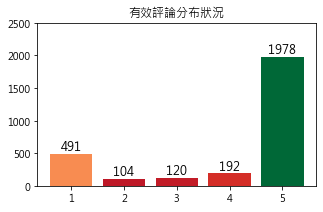

In [12]:
labels = ['1', '2', '3', '4', '5']
x = data2.iloc[:,0]
ratings = [sum(x==1), sum(x==2), sum(x==3), sum(x==4), sum(x==5)]

plt.figure(figsize=(5,3))

#根據數值上不同顏色
col = np.array(ratings)/max(ratings)
col = plt.cm.RdYlGn(col)

plt.bar(labels, ratings, color=col)

plt.ylim([0,2500]) # y軸範圍

#修改座標名稱
plt.xticks(np.arange(5), labels=labels)

rects = plt.bar(labels, ratings, color=col)
for rect in rects:  #rects 是三根柱子的集合
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=12, ha='center', va='bottom')

    
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('有效評論分布狀況')

In [13]:
print('1:',sum(x==1))
print('2:',sum(x==2))
print('3:',sum(x==3))
print('4:',sum(x==4))
print('5:',sum(x==5))

1: 491
2: 104
3: 120
4: 192
5: 1978


In [14]:
comment = data2.iloc[:,1]
comment

0        真的超級難看沒頭沒尾沒有重點沒有結局劇情莫名其妙拉低國片的水準這部內容應該是市井小民的無聊生活片
1                             不虧是金馬黃導的片低俗下流沒頭沒尾推薦時間很多的人來看
2                                                    超無聊的
3                        明明一樣超好笑的啊比較草根性的人比較會有感覺這才是正港的台灣國片
4       我很難理解這部片入圍最佳劇情長片大部分的笑點都令人尷尬糟蹋一票好演員無聲和腿腿令人驚喜都更有...
                              ...                        
2880               這集恐怖的點在於老一輩可怕的飼養觀念以及第一線人員受到的刁難與艱辛真的心很酸
2881                             真的很棒影片在談論的議題許多人的努力非常值得一看
2882                       領養代替購買節育代替撲殺除了是口號觀念外也是要長久持續的進行
2883    很感動向這些為動物社會努力的人致敬儘管我們市井小民或許很難直接的出一份心力但我想只要多數人心...
2884               支持領養代替購買每隻貓狗都是生命他們只是遇到不對的飼主世上還是有很多好的飼主
Name: comment, Length: 2885, dtype: object

In [15]:
print(len(comment))

2885


# JIEBA

```1是繁體切 2是轉簡體切完後轉回繁體```

In [16]:
print(list(jieba.cut("".join(comment[2881]))))

['真的', '很棒', '影片', '在', '談論', '的', '議題', '許多人', '的', '努力', '非常', '值得一看']


In [17]:
print(list(jieba.cut(HanziConv.toSimplified("".join(comment[2881])))))

['真的', '很棒', '影片', '在', '谈论', '的', '议题', '许多', '人', '的', '努力', '非常', '值得一看']


In [18]:
def restore(text, toks):
    results = []
    offset = 0
    for tok in toks:
        results.append(text[offset:offset + len(tok)])
        offset += len(tok)
    return results

text = "".join(comment[0])
print(restore(text, list(jieba.cut(HanziConv.toSimplified(text)))))

['真的', '超級', '難看', '沒頭沒尾', '沒有', '重點', '沒有', '結局', '劇情', '莫名其妙', '拉低', '國片', '的', '水準', '這部', '內容', '應該', '是', '市井小民', '的', '無聊', '生活', '片']


In [19]:
comment1 = []
comment2 = []
for i in range(len(comment)):
    comment1.append(list(jieba.cut("".join(comment[i]))))
    text = "".join(comment[i])
    comment2.append(restore(text, list(jieba.cut(HanziConv.toSimplified(text)))))

In [20]:
print(len(comment1))
print(len(comment2))

2885
2885


## 去除停用字

In [21]:
stop_word = []

with open('D:\desktop\論文\stopWords.txt', 'r', encoding='utf-8') as f:
    stop_ls = f.readlines()
    stop_word = [i.strip() for i in stop_ls]

In [22]:
def remove_stopwords(tokens):
    tokens_clean = []
    for tok in tokens:
        if tok not in stop_word:
            tokens_clean.append(tok)
    return tokens_clean

In [23]:
stop_comment1 = []
for j in range(len(comment1)):
    stop_comment1.append(remove_stopwords(comment1[j]))

In [24]:
stop_comment2 = []
for j in range(len(comment2)):
    stop_comment2.append(remove_stopwords(comment2[j]))

In [25]:
print((stop_comment1[2881]))

['真的', '很棒', '影片', '談論', '議題', '許多人', '努力', '值得一看']


In [26]:
stop_comment1

[['真的',
  '超級',
  '難',
  '沒頭',
  '沒尾',
  '重點',
  '結局',
  '劇情',
  '莫名其妙',
  '拉低',
  '國片',
  '水準',
  '這部',
  '內容',
  '應該',
  '市井小民',
  '無聊',
  '生活',
  '片'],
 ['不虧', '金馬黃導', '片', '低俗', '下流', '沒頭', '沒尾', '推薦', '時間', '人來'],
 ['超無聊'],
 ['明明', '超', '好笑', '草根', '性', '人', '有感', '覺', '這才', '正港', '台灣國片'],
 ['難',
  '理解',
  '這部片',
  '入圍',
  '最佳',
  '劇情',
  '長',
  '片',
  '大部分',
  '笑點',
  '令人',
  '尷尬',
  '糟蹋',
  '一票',
  '好',
  '演員無聲',
  '腿',
  '腿',
  '令人',
  '驚喜',
  '資格',
  '入圍',
  '這是',
  '一部',
  '台式',
  '爽片',
  '難',
  '賣',
  '國外',
  '最諷',
  '刺',
  '裡面',
  '後',
  '來當',
  '立委',
  '腳色',
  '原本',
  '夢',
  '想',
  '拍出',
  '世界',
  '看見',
  '台灣',
  '電影',
  '照黃姓',
  '導演',
  '這種',
  '拍法',
  '最後就會',
  '玩壞',
  '說',
  '走',
  '出台',
  '灣了'],
 ['看過',
  '大佛',
  '普拉斯',
  '後',
  '覺得',
  '感動',
  '想',
  '說',
  '同學',
  '麥娜',
  '絲會',
  '好',
  '看看',
  '完',
  '後',
  '真的',
  '覺得',
  '大佛',
  '普拉斯',
  '好看'],
 ['只能', '說', '說', '無聊', '人', '玩命', '關頭', '喔', '上映'],
 ['人感', '覺劇', '情編', '排比', '鬆', '散', '容', '沉悶'],
 ['感覺',
  '只',
  '想法

## 計算詞彙

In [27]:
set_comment1 = []
for i in range(len(comment1)):
    set_1 = set(comment1[i])
    for j in set_1:
        set_comment1.append(j)

len(set(set_comment1))

11871

In [25]:
set_comment2 = []
for i in range(len(comment2)):
    set_2 = set(comment2[i])
    for j in set_2:
        set_comment2.append(j)

len(set(set_comment2))

9333

In [26]:
set_stop_comment1 = []
for i in range(len(stop_comment1)):
    set_stop_1 = set(stop_comment1[i])
    for j in set_stop_1:
        set_stop_comment1.append(j)

len(set(set_stop_comment1))

11412

In [27]:
set_stop_comment2 = []
for i in range(len(stop_comment2)):
    set_stop_2 = set(stop_comment2[i])
    for j in set_stop_2:
        set_stop_comment2.append(j)

len(set(set_stop_comment2))

8829

## 查看個詞彙出現次數

In [28]:
from collections import Counter
total = 0
cnt = Counter()
for sent in comment1:
    for tok in sent:
        cnt[tok] += 1
        total += 1

In [31]:
total2 = 0
cnt2 = Counter()
for sent in comment2:
    for tok in sent:
        cnt2[tok] += 1
        total2 += 1

In [34]:
total = 0
cnt3 = Counter()
for sent in stop_comment1:
    for tok in sent:
        cnt3[tok] += 1
        total += 1

## 計算TFIDF可能維度

# WordEmbedding

## TF-IDF

### 1

In [28]:
tfidf_comment1 = []
for j in range(len(stop_comment1)):
    for i in range(len(stop_comment1[j])-1):
        stop_comment1[j][0] = stop_comment1[j][0] + " " + stop_comment1[j][i+1]
    tfidf_comment1.append(stop_comment1[j][0])

In [29]:
len(tfidf_comment1)

2885

In [30]:
tfidf_comment1[2015]

'音樂 好 聽 劇情 故事 有趣 感人 推薦'

In [31]:
tfidf_comment1

['真的 超級 難 沒頭 沒尾 重點 結局 劇情 莫名其妙 拉低 國片 水準 這部 內容 應該 市井小民 無聊 生活 片',
 '不虧 金馬黃導 片 低俗 下流 沒頭 沒尾 推薦 時間 人來',
 '超無聊',
 '明明 超 好笑 草根 性 人 有感 覺 這才 正港 台灣國片',
 '難 理解 這部片 入圍 最佳 劇情 長 片 大部分 笑點 令人 尷尬 糟蹋 一票 好 演員無聲 腿 腿 令人 驚喜 資格 入圍 這是 一部 台式 爽片 難 賣 國外 最諷 刺 裡面 後 來當 立委 腳色 原本 夢 想 拍出 世界 看見 台灣 電影 照黃姓 導演 這種 拍法 最後就會 玩壞 說 走 出台 灣了',
 '看過 大佛 普拉斯 後 覺得 感動 想 說 同學 麥娜 絲會 好 看看 完 後 真的 覺得 大佛 普拉斯 好看',
 '只能 說 說 無聊 人 玩命 關頭 喔 上映',
 '人感 覺劇 情編 排比 鬆 散 容 沉悶',
 '感覺 只 想法 階段 劇本 意念 尚未 成熟 作品 人物 厚度 不夠 演員 難 發揮 相較 金馬 得獎 作品 這片 真的 差太多',
 '劇情 平淡 高潮迭起 平淡 內容',
 '好看 已五刷 喜歡 大佛 普拉斯 朋友 一定 失望 推',
 '認真覺 得劇 情編 排 鬆 散 話 無 聊 選 角 問 題 推 繼續 溫層 王彩樺 平時 演藝圈 搞笑 久 這部當 淑女 特別 人出 戲瓦樂莉 大佛 演 表情 賤 到位 這部 卻 變成 綠茶 婊台 詞講 生硬 一堆 莫名 鏡頭 導演 跳 踹 人 閉節 車上 唱歌 閉節 台 中公園 喊 凍 蒜 濁 水溪樂團 唱 打手 槍 最 後 一群 人露 臉 嗨 笑點 鏡頭 安排 邏輯 自以 看得懂 文青會 笑 大佛 優 這部 水準 降低 成 Minus 不行 講 髒 話 代表 呈現 出道 鄉 土味 過度 呈現 畫蛇 添足',
 '情 慾 呈現 方式 覺得 太 低俗 人覺 噁 心納豆 身材 人 秒 出戲 劇情 年紀 不到 無法產 生共鳴 朋友 請客 直接 睡著',
 '這部片 覺得 好看 演四個 人 故事 納豆 超 好笑',
 '劇情 真的 無 聊到 再無聊 結局 莫名其妙 電影 結束 時 候電 影院 燈 一打 亮 感覺 整個電 影院 人 每個 人 無言 互看 然後頭 一堆 問號 電影布幕 跑 馬 燈 擋 住 真的 錢 鬼 滅三刷

## 計算TFIDF

###  D=50

In [32]:
vectorizer = TfidfVectorizer(max_features=50, smooth_idf=True, norm='l2')
vectorizer.fit_transform(tfidf_comment1)
tfidf_1 = vectorizer.fit_transform(tfidf_comment1)

In [33]:
word1 = vectorizer.get_feature_names() # 獲取詞袋模型中的所有詞語

In [34]:
pd_tfidf1 = pd.DataFrame(tfidf_1.toarray())

###  D=100

In [36]:
vectorizer = TfidfVectorizer(max_features=100, smooth_idf=True, norm='l2')
vectorizer.fit_transform(tfidf_comment1)
tfidf_2 = vectorizer.fit_transform(tfidf_comment1)

In [37]:
word1 = vectorizer.get_feature_names() # 獲取詞袋模型中的所有詞語

In [38]:
#pd_tfidf2 = pd.DataFrame(tfidf_2.toarray(), columns = word1)
pd_tfidf2 = pd.DataFrame(tfidf_2.toarray())

###  D=150

In [39]:
vectorizer = TfidfVectorizer(max_features=150, smooth_idf=True, norm='l2')
vectorizer.fit_transform(tfidf_comment1)
tfidf_3 = vectorizer.fit_transform(tfidf_comment1)

In [40]:
word1 = vectorizer.get_feature_names() # 獲取詞袋模型中的所有詞語
pd_tfidf3 = pd.DataFrame(tfidf_3.toarray())

### D=200

In [41]:
vectorizer = TfidfVectorizer(max_features=200, smooth_idf=True, norm='l2')
vectorizer.fit_transform(tfidf_comment1)
tfidf_4 = vectorizer.fit_transform(tfidf_comment1)

In [42]:
word1 = vectorizer.get_feature_names() # 獲取詞袋模型中的所有詞語
pd_tfidf4 = pd.DataFrame(tfidf_4.toarray())

## cosine similariry

# wiki word embedding

In [147]:
from gensim.models import Word2Vec

In [148]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format("D:\desktop\論文\wiki.zh.vec", binary=False) # binary: .txt
print("Number of words: %d" % len(w2v.vocab))

Number of words: 332647


In [149]:
D = 300
comment1_wiki=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(w2v[w])
        except:
            sent_array.append(np.zeros(D,))
    comment1_wiki.append(np.mean(sent_array,axis=0).tolist())

In [150]:
len(comment1_wiki[0])

300

# CBOW

In [151]:
D = 50

In [152]:
model_cbow1 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=0, hs=1, negative=5, iter=10)

In [153]:
comment1_cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow1[w])
        except:
            sent_array.append(np.zeros(D,))
    comment1_cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-153-ccaa570fe698>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow1[w])


In [154]:
len(comment1_cbow[0])

50

In [155]:
D = 100
model_cbow2 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=0, hs=1, negative=5, iter=10)

In [156]:
comment2_cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow2[w])
        except:
            sent_array.append(np.zeros(D,))
    comment2_cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-156-03b14004d3c4>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow2[w])


In [157]:
len(comment2_cbow[0])

100

In [158]:
D = 150
model_cbow3 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=0, hs=1, negative=5, iter=10)

In [159]:
comment3_cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow3[w])
        except:
            sent_array.append(np.zeros(D,))
    comment3_cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-159-94651f4362f4>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow3[w])


In [160]:
len(comment3_cbow[0])

150

In [161]:
D = 200
model_cbow4 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=0, hs=1, negative=5, iter=10)

In [162]:
comment4_cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow4[w])
        except:
            sent_array.append(np.zeros(D,))
    comment4_cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-162-5967c2d1e7bd>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow4[w])


In [163]:
len(comment4_cbow[0])

200

### w=5

In [164]:
D = 50

In [165]:
model_cbow1_1 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=0, hs=1, negative=5, iter=10)

In [166]:
comment1_1cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow1_1[w])
        except:
            sent_array.append(np.zeros(D,))
    comment1_1cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-166-3b8594b24208>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow1_1[w])


In [167]:
len(comment1_1cbow[0])

50

In [168]:
D = 100
model_cbow2_2 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=0, hs=1, negative=5, iter=10)

In [169]:
comment2_2cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow2_2[w])
        except:
            sent_array.append(np.zeros(D,))
    comment2_2cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-169-7897ad62dab7>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow2_2[w])


In [170]:
len(comment2_2cbow[0])

100

In [171]:
D = 150
model_cbow3_3 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=0, hs=1, negative=5, iter=10)

In [172]:
comment3_3cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow3_3[w])
        except:
            sent_array.append(np.zeros(D,))
    comment3_3cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-172-757b82818994>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow3_3[w])


In [173]:
len(comment3_3cbow[0])

150

In [174]:
D = 200
model_cbow4_4 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=0, hs=1, negative=5, iter=10)

In [175]:
comment4_4cbow=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_cbow4_4[w])
        except:
            sent_array.append(np.zeros(D,))
    comment4_4cbow.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-175-4b758e8ef68e>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_cbow4_4[w])


In [176]:
len(comment4_4cbow[0])

200

# Skip-gram

In [177]:
D = 50

In [178]:
model_skip1 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=1, hs=1, negative=5, iter=10)

In [179]:
comment1_skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip1[w])
        except:
            sent_array.append(np.zeros(D,))
    comment1_skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-179-d75b0f611293>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip1[w])


In [180]:
len(comment1_skip[0])

50

In [181]:
D = 100

In [182]:
model_skip2 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=1, hs=1, negative=5, iter=10)

In [183]:
comment2_skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip2[w])
        except:
            sent_array.append(np.zeros(D,))
    comment2_skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-183-560da08f3aa3>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip2[w])


In [184]:
len(comment2_skip[0])

100

In [185]:
D = 150

In [186]:
model_skip3 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=1, hs=1, negative=5, iter=10)

In [187]:
comment3_skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip3[w])
        except:
            sent_array.append(np.zeros(D,))
    comment3_skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-187-279576ae6077>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip3[w])


In [188]:
len(comment3_skip[0])

150

In [189]:
D = 200

In [190]:
model_skip4 =  Word2Vec(stop_comment1, size=D , min_count=5, window=3, sg=1, hs=1, negative=5, iter=10)

In [191]:
comment4_skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip4[w])
        except:
            sent_array.append(np.zeros(D,))
    comment4_skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-191-3e7d90055fcc>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip4[w])


In [192]:
len(comment4_skip[0])

200

### w = 5

In [193]:
D = 50

In [194]:
model_skip1_1 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=1, hs=1, negative=5, iter=10)

In [195]:
comment1_1skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip1_1[w])
        except:
            sent_array.append(np.zeros(D,))
    comment1_1skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-195-0bdd4b4f77a6>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip1_1[w])


In [196]:
len(comment1_1skip[0])

50

In [197]:
D = 100
model_skip2_2 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=1, hs=1, negative=5, iter=10)

In [198]:
comment2_2skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip2_2[w])
        except:
            sent_array.append(np.zeros(D,))
    comment2_2skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-198-566c4287ede7>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip2_2[w])


In [199]:
len(comment2_2skip[0])

100

In [200]:
D = 150
model_skip3_3 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=1, hs=1, negative=5, iter=10)

In [201]:
comment3_3skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip3_3[w])
        except:
            sent_array.append(np.zeros(D,))
    comment3_3skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-201-bc3463b0a4a5>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip3_3[w])


In [202]:
len(comment3_3skip[0])

150

In [203]:
D = 200
model_skip4_4 =  Word2Vec(stop_comment1, size=D , min_count=5, window=5, sg=1, hs=1, negative=5, iter=10)

In [204]:
comment4_4skip=[]
for sent in stop_comment1:
    sent_array=[]
    for w in sent:
        try:
            sent_array.append(model_skip4_4[w])
        except:
            sent_array.append(np.zeros(D,))
    comment4_4skip.append(np.mean(sent_array,axis=0).tolist())

<ipython-input-204-02a5385b4cbf>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sent_array.append(model_skip4_4[w])


In [205]:
len(comment4_4skip[0])

200

In [218]:
comment2_skip[2]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [221]:
stop_comment1[179]

['糞片']

In [213]:
test = pd.DataFrame(np.array(comment4_4skip))

In [214]:
test

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.121160,-0.016213,-0.123213,-0.312785,0.010947,0.014390,-0.041392,-0.216406,0.131413,0.017845,...,0.043114,-0.066256,-0.021302,-0.065556,0.077125,0.062762,0.059519,0.097535,0.051377,0.126634
1,-0.082780,-0.067486,-0.113573,-0.275297,0.011999,0.015859,-0.062180,-0.127661,0.040060,0.018043,...,0.019768,0.000629,-0.088197,-0.063157,0.030458,0.022082,0.031286,0.106643,0.018618,0.081543
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.004820,-0.017273,0.032654,-0.051757,0.002451,0.027503,0.003315,-0.083869,0.096274,-0.043801,...,0.107474,-0.105322,0.016799,-0.021162,0.130527,0.073433,0.019985,0.059057,0.035454,0.012674
4,-0.056075,-0.031835,-0.024047,-0.175122,-0.015418,-0.005621,-0.004496,-0.092005,0.057720,-0.006816,...,0.072694,-0.030179,0.023106,-0.048566,0.026061,0.044319,0.022486,0.024039,0.029401,0.053268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,-0.025830,0.004129,-0.066276,-0.227954,-0.073104,-0.040305,-0.014781,-0.135910,0.057607,-0.058490,...,0.023715,-0.037260,-0.043111,-0.049188,0.054166,-0.012296,0.018050,0.003051,0.028387,0.071207
2881,-0.023473,0.001709,-0.038217,-0.080610,-0.054099,-0.020201,0.051824,-0.071579,0.144584,-0.016222,...,0.109662,-0.027177,0.000812,-0.068342,0.063705,0.035374,0.014189,0.023313,0.020327,0.081180
2882,-0.053658,-0.039017,-0.005474,-0.108885,-0.056339,-0.010601,0.012114,-0.059064,-0.029383,-0.036514,...,0.008095,-0.003467,0.001745,-0.022597,0.020671,-0.010198,0.023214,0.028092,0.008595,-0.035966
2883,-0.047610,-0.074711,-0.031446,-0.147848,-0.083279,-0.062479,0.033602,-0.090650,0.050576,-0.024255,...,0.111297,-0.018836,0.012696,-0.087410,0.002172,0.016261,0.043080,0.011894,0.038326,0.020102


## 輸出

In [43]:
rating = data2.iloc[:,0]

In [44]:
def embedding_vector_tocsv2(X, name):
    Y_name = name
    #X = pd.DataFrame(np.array(Y))
    final = pd.concat([rating, X], axis = 1)
    final.to_csv("D:\\desktop\\論文\\data\\文字輸出\\" + Y_name + '.csv', index=False, encoding='utf_8_sig')

In [45]:
# TFIDF
embedding_vector_tocsv2(pd_tfidf1, 'yahoo_tfidf1') # D=50
embedding_vector_tocsv2(pd_tfidf2, 'yahoo_tfidf2') # D=100
embedding_vector_tocsv2(pd_tfidf3, 'yahoo_tfidf3') # D=150
embedding_vector_tocsv2(pd_tfidf4, 'yahoo_tfidf4') # D=200

In [110]:
def embedding_vector_tocsv(Y, name):
    Y_name = name
    X = pd.DataFrame(np.array(Y))
    final = pd.concat([rating, X], axis = 1)
    final.to_csv("D:\\desktop\\論文\\data\\文字輸出\\" + Y_name + '.csv', index=False, encoding='utf_8_sig')

In [209]:
# wiki
embedding_vector_tocsv(comment1_wiki, 'yahoo_wiki') # D=300

In [210]:
# CBOW
embedding_vector_tocsv(comment1_cbow, 'yahoo_cbow1_1') # w=3, D=50
embedding_vector_tocsv(comment2_cbow, 'yahoo_cbow1_2') # w=3, D=100
embedding_vector_tocsv(comment3_cbow, 'yahoo_cbow1_3') # w=3, D=150
embedding_vector_tocsv(comment4_cbow, 'yahoo_cbow1_4') # w=3, D=200

embedding_vector_tocsv(comment1_1cbow, 'yahoo_cbow2_1') # w=5, D=50
embedding_vector_tocsv(comment2_2cbow, 'yahoo_cbow2_2') # w=5, D=100
embedding_vector_tocsv(comment3_3cbow, 'yahoo_cbow2_3') # w=5, D=150
embedding_vector_tocsv(comment4_4cbow, 'yahoo_cbow2_4') # w=5, D=200


In [211]:
# Skip-gram
embedding_vector_tocsv(comment1_skip, 'yahoo_skip1_1') # w=3, D=50
embedding_vector_tocsv(comment2_skip, 'yahoo_skip1_2') # w=3, D=100
embedding_vector_tocsv(comment3_skip, 'yahoo_skip1_3') # w=3, D=150
embedding_vector_tocsv(comment4_skip, 'yahoo_skip1_4') # w=3, D=200

embedding_vector_tocsv(comment1_1skip, 'yahoo_skip2_1') # w=5, D=50
embedding_vector_tocsv(comment2_2skip, 'yahoo_skip2_2') # w=5, D=100
embedding_vector_tocsv(comment3_3skip, 'yahoo_skip2_3') # w=5, D=150
embedding_vector_tocsv(comment4_4skip, 'yahoo_skip2_4') # w=5, D=200

In [208]:
stop_comment1[155]

['垃圾',
 '難',
 '看到',
 '爆生',
 '下來',
 '看過',
 '爛到',
 '電影',
 '浪費',
 '錢',
 '還浪費',
 '時間',
 '毫無優點',
 '一部',
 '爛片']

In [174]:
def embedding_vector(Y):
    Y_name = str(Y)
    X = pd.DataFrame(np.array(Y))
    final = pd.concat([data2.iloc[:,0], X], axis = 1)
    return(final)

In [175]:
def embedding_vector_tocsv(Y, name):
    Y_name = name
    X = pd.DataFrame(np.array(Y))
    final = pd.concat([rating, X], axis = 1)
    final.to_csv("D:\\desktop\\自然語言處理\csv\\" + Y_name + '.csv', index=False, encoding='utf_8_sig')

In [176]:
rating = data2.iloc[:,0]

In [386]:
# wiki
embedding_vector_tocsv(comment1_wiki, 'comment1_wiki')
embedding_vector_tocsv(comment2_wiki, 'comment2_wiki')
embedding_vector_tocsv(comment3_wiki, 'comment3_wiki')
embedding_vector_tocsv(comment4_wiki, 'comment4_wiki')

# CBOW
embedding_vector_tocsv(comment1_cbow, 'comment1_cbow')
embedding_vector_tocsv(comment2_cbow, 'comment2_cbow')
embedding_vector_tocsv(comment3_cbow, 'comment3_cbow')
embedding_vector_tocsv(comment4_cbow, 'comment4_cbow')

# Skip-gram
embedding_vector_tocsv(comment1_skip, 'comment1_skip')
embedding_vector_tocsv(comment2_skip, 'comment2_skip')
embedding_vector_tocsv(comment3_skip, 'comment3_skip')
embedding_vector_tocsv(comment4_skip, 'comment4_skip')

In [74]:
def embedding_vector_tocsv2(X, name):
    Y_name = name
    #X = pd.DataFrame(np.array(Y))
    final = pd.concat([rating, X], axis = 1)
    final.to_csv("D:\\desktop\\自然語言處理\csv\\" + Y_name + '.csv', index=False, encoding='utf_8_sig')

In [75]:
# TFIDF
embedding_vector_tocsv2(pd_tfidf1, 'pd_tfidf1')
#embedding_vector_tocsv(pd_tfidf2, 'pd_tfidf2')
#embedding_vector_tocsv(pd_tfidf3, 'pd_tfidf3')
#embedding_vector_tocsv(pd_tfidf4, 'pd_tfidf4')